# Prédiction de documents au sein d'un corpus

## Objectif principal : 

Trouver les motifs définissant une œuvre au sein d'un même corpus.

## Méthodologie :

Nous utilisons pour atteindre cet objectif une technique de classification linéaire multinomiale (> à deux classes à prédire) qui prend la forme suivante :
$$y_i = \alpha_1 X_{i1} + \alpha_2 X_{i2} + \ldots + \alpha_p X_{ip} = f_\alpha(X)$$
où $y$ indique le document $i$ et $X_i$ est un vecteur de caractéristiques (*features*) calculé à partir de motifs de longueur $p$ pour le document $i$.

La régression logistique multinomiale (ou modèle logit multinomial) est une généralisation de la régression logistique binaire qui permet de modéliser des variables dépendantes de nature catégorielle avec plus de deux modalités. Ce modèle est couramment utilisé en statistiques et en apprentissage automatique pour prédire des variables cibles

Au lieu d'adapter ce classificateur au niveau de l'oeuvre, nous divisons chaque oeuvre du corpus en fenêtres de longueur fixe qui représentent alors les documents $i \in \{1, \ldots, n\}$. Nous obtenons ainsi une forte hausse du nombre d'observations sur lesquelles le modèles va s'entraîner et ensuite être testé. 

Nous appliquons le pipeline afin d'obtenir les annotations de motifs (ou toute autre *feature*, si on le souhaitait...). Ensuite, nous calculons les $X_i$ qui sont définis comme les scores TFIDF de chaque motif dans chaque document du corpus, où un document représente une fenêtre de motifs, comme indiqué ci-dessus.

### Présélection des caractéristiques

Dans ce cas d'étude, $p$ est très grand ($>200K$), nous introduisons donc un critère de sélection des caractéristiques avant d'estimer les paramètres. Puisque nous savons qu'un token qui a un tfidf de 0 correspond à des tokens non-informatifs, nous proposons une solution simple basée sur la rareté de la caractéristique $X_{ :,j}$. Nous définissons le niveau de rareté comme la proportion de 0 dans un vecteur : $\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{X_{i,j} = 0\}$. Plus le token est épars (*sparse*) dans le corpus, moins il est informatif, puisqu'il est plus commun à tous les documents. Ensuite, nous sélectionnons simplement les $P$ caractéristiques les moins éparses.

### Estimation

Pour ajuster le modèle, nous minimisons l'erreur quadratique moyenne comme dans un cadre classique de régression logistique multinomiale. Cependant, afin de sélectionner les motifs les plus importants, nous appliquons la régularisation L1 qui force les caractéristiques non informatives à avoir un coefficient de 0.

> La régularisation L1 (également appelée Lasso pour "Least Absolute Shrinkage and Selection Operator") est une technique utilisée en apprentissage automatique et en statistiques pour prévenir le surapprentissage (overfitting) et améliorer la généralisation des modèles. Cette technique fonctionne en ajoutant une pénalité au terme de coût du modèle, ce qui permet de contrôler la complexité du modèle et d'encourager la parcimonie (ou sparsité) des coefficients.


### Évaluation

Pour évaluer le modèle, nous divisons les données en échantillons de formation et de test, où les observations de l'échantillon de test proviennent de documents qui ne font pas partie de l'échantillon de formation. Enfin, nous utilisons la métrique de précision sur l'ensemble de test.

## Import des librairies

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

from motifs.pipeline import Pipeline
from motifs.features import build_tfidf, transform_corpus_to_ngrams
from motifs.utils import build_window_corpus, return_to_text_from_token

On commence, comme dans le premier cas d'étude, par récupérer notre corpus tokénisé et annoté pour le transformer en séquences de ngrams.

In [26]:
# Define the path of the corpus
# tokens_dir = None
tokens_dir="/Users/antoinedesacy/Documents/py-motifs-formation/HZH/corpus/tokens"
corpus_dir = None
# Define the token type: AVAILABLE_TOKEN_TYPES = ["text", "lemma", "pos", "motif"]
token_type = "motif"
# n-gram length
n = 5

pipeline = Pipeline(token_type, corpus_dir=corpus_dir, tokens_dir=tokens_dir, save=False)
pipeline.transform_to_ngrams(n)
ngrams = pipeline.ngrams
ngrams.head()

[PyMotifs-Logger:pipeline.py:96] - [49861] - 2024-09-29 15:34:54 - DEBUG - Loading tokens from directory: /Users/antoinedesacy/Documents/py-motifs-formation/HZH/corpus/tokens...
[PyMotifs-Logger:pipeline.py:99] - [49861] - 2024-09-29 15:34:56 - DEBUG - Done in 1.13 secs.
[PyMotifs-Logger:features.py:49] - [50546] - 2024-09-29 15:35:02 - DEBUG - Steps to go 9
[PyMotifs-Logger:features.py:49] - [50549] - 2024-09-29 15:35:02 - DEBUG - Steps to go 10
[PyMotifs-Logger:features.py:49] - [50550] - 2024-09-29 15:35:02 - DEBUG - Steps to go 7
[PyMotifs-Logger:features.py:49] - [50566] - 2024-09-29 15:35:02 - DEBUG - Steps to go 5
[PyMotifs-Logger:features.py:49] - [50559] - 2024-09-29 15:35:02 - DEBUG - Steps to go 6
[PyMotifs-Logger:features.py:49] - [50558] - 2024-09-29 15:35:02 - DEBUG - Steps to go 8
[PyMotifs-Logger:features.py:49] - [50562] - 2024-09-29 15:35:02 - DEBUG - Steps to go 4
[PyMotifs-Logger:features.py:49] - [50560] - 2024-09-29 15:35:02 - DEBUG - Steps to go 3
[PyMotifs-Logge

word                         text                  token  \
0  Prologue  Prologue Ce livre est avant    NC ce NC être avant   
1        Ce      Ce livre est avant tout  ce NC être avant tout   
2     livre      livre est avant tout l'  NC être avant tout le   
3       est   est avant tout l' histoire  être avant tout le NC   
4     avant    avant tout l' histoire d'    avant tout le NC de   

                                                 doc  
0  1998_Houellebecq-Michel_Les-particules-element...  
1  1998_Houellebecq-Michel_Les-particules-element...  
2  1998_Houellebecq-Michel_Les-particules-element...  
3  1998_Houellebecq-Michel_Les-particules-element...  
4  1998_Houellebecq-Michel_Les-particules-element...

In [27]:
# Let's see which document we have within our corpus : 
ngrams['doc'].unique().tolist()


['1998_Houellebecq-Michel_Les-particules-elementaires',
 '1891_Huysmans-Joris-Karl_La-bas',
 '1873_Zola-Emile_Le-ventre-de-Paris',
 '1870_Zola-Emile_La-fortune-des-Rougon',
 '1872_Zola-Emile_La-curee',
 '2005_Houellebecq-Michel_La-possibilite-d-une-ile',
 '2001_Houellebecq-Michel_Plateforme',
 '1877_Zola-Emile_L-assommoir',
 '1887_Huysmans-Joris-Karl_Un-dilemme',
 '1884_Huysmans-Joris-Karl_a-rebours']

## Fenêtres de longueur fixes dans chaque texte

Commençons tout d'abord par découper les textes de notre corpus en fenêtres de longueur fixe auxquelles nous donnerons une étiquette correspondant à l'oeuvre dans laquelle figure le token. La classe à prédire correspond ici au document, au roman. Nous augmentons ainsi artificiellement le nombre d'observations à prédire au sein de notre corpus en entraînant le modèle à prédire une classe au niveau d'un sous-échantillon de chacune des oeuvres.

In [28]:
seq_length = 5000
data = build_window_corpus(ngrams, seq_length)
# Create class mapper
class_mapper = {d: i for i, d in enumerate(data["doc"].unique())}
data["class"] = [class_mapper[data["doc"][i]] for i in range(len(data))]
data["doc"] = data["doc"] + "_w_" + data["window"].astype(str)
doc = data.doc.unique().tolist()
data.head()

window                         text                  token  \
0       0  Prologue Ce livre est avant    NC ce NC être avant   
1       0      Ce livre est avant tout  ce NC être avant tout   
2       0      livre est avant tout l'  NC être avant tout le   
3       0   est avant tout l' histoire  être avant tout le NC   
4       0    avant tout l' histoire d'    avant tout le NC de   

                                                 doc  class  
0  1998_Houellebecq-Michel_Les-particules-element...      0  
1  1998_Houellebecq-Michel_Les-particules-element...      0  
2  1998_Houellebecq-Michel_Les-particules-element...      0  
3  1998_Houellebecq-Michel_Les-particules-element...      0  
4  1998_Houellebecq-Michel_Les-particules-element...      0

Ce qui nous donne x fenêtres par oeuvre.

In [29]:
doc

['1998_Houellebecq-Michel_Les-particules-elementaires_w_0',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_5000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_10000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_15000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_20000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_25000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_30000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_35000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_40000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_45000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_50000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_55000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_60000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_65000',
 '1998_Houellebecq-Michel_Les-particules-elementaires_w_70000',
 '1998_Houellebecq-Michel_Les-particules-elem

## Class distribution

On peut commencer par analyser les différentiels de volume entre ces différentes fenêtres pour avoir une vision globale du déséquilibre de nos classes.

<Axes: xlabel='class', ylabel='proportion'>

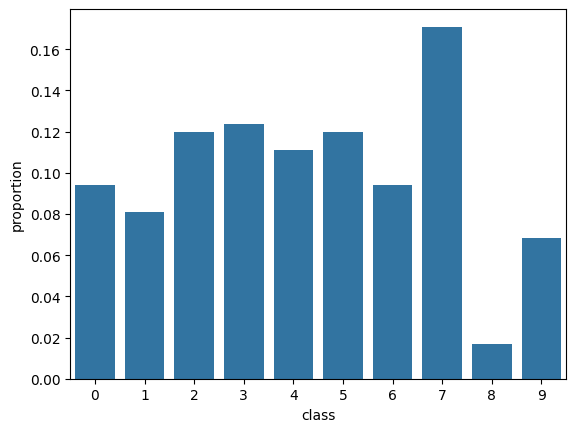

In [30]:
windows = data[["doc", "class"]].drop_duplicates(keep="first")
sns.countplot(windows, x="class", stat="proportion")

On observe clairement une disproportion au niveau des différentes classes, certaines étant bien plus importantes que d'autres. Il nous faudra procéder à une régularisation de cette différence lors de la prochaine étape.

## Train/test split

La division des données en ensembles d'entraînement (train set) et de test (test set) est une étape cruciale dans le cadre de l'apprentissage supervisé. Cela permet d'évaluer la performance du modèle et de vérifier sa capacité à généraliser à des données non observées (ou inconnues).

Pourquoi diviser les données en ensembles d’entraînement et de test ? La division des données en deux ensembles distincts a pour but de :

- Entraîner le modèle sur une partie des données (appelée train set) pour ajuster les paramètres (comme les coefficients dans une régression logistique).
- Tester la performance du modèle sur des données qu'il n'a jamais vues (appelée test set). Cela permet d'évaluer comment le modèle se généralise à de nouvelles données et d’éviter le sur-apprentissage (overfitting).

Comme dit précédemment, le déséquilibre observé nous incite à procéder à une régularisation afin de ne pas déséquilibrer le modèle et l'influencer à prédire la classe la plus dominante. Pour cela, nous utilisons un procédé appelé le StratifiedShuffleSplit, méthode de validation croisée (cross-validation) de la bibliothèque *scikit-learn*, spécifiquement conçue pour gérer des données avec des étiquettes déséquilibrées. Contrairement à une validation croisée classique, qui répartit les données de manière aléatoire sans tenir compte de la distribution des classes, le StratifiedShuffleSplit garantit que la proportion de chaque classe dans les données est maintenue dans chaque ensemble d'entraînement et de test.

In [31]:
test_size = 0.3
random_state = 0 # For reproducibility
np.random.seed(random_state)
# Use StratifiedShuffleSplit to keep class balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
train_idx, test_idx = list(sss.split(windows["doc"], windows["class"]))[0]

train_data = data[data["doc"].isin(windows.iloc[train_idx]["doc"])]
test_data = data[data["doc"].isin(windows.iloc[test_idx]["doc"])]

## Featurization (TFIDF)

Notre régression logisitique utilisera les scores de Tf-IDF sur les motifs afin de procéder à la prédiction de chacun des segments (fenêtres) à chacune des classes (chaque oeuvre du corpus). 

In [32]:
## Train set

t1 = time.time()
train_tfidf, model, dictionary = build_tfidf(train_data, normalize=False, smartirs="nfn")
t2 = time.time()
print(f"{t2-t1:.2f}")

# Test set
t1 = time.time()
test_tfidf, _, _ = build_tfidf(test_data, model=model, dictionary=dictionary, normalize=False, smartirs="nfn") # Use train_idf
t2 = time.time()
print(f"{t2-t1:.2f}")

41.40
17.98


In [33]:
# Transform to a table with documents as indices and tokens as columns
t1 = time.time()
train_tfidf = train_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")
t1 = time.time()
test_tfidf = test_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")

(train_tfidf.shape, test_tfidf.shape)

73.54
39.28


((163, 428980), (71, 568892))

Certains tokens apparaissent dans le jeu d'entraînement qui ne sont pas dans le jeu de test, nous les ramenons à 0 quoi qu'il arrive pour qu'ils équilibrer les observations entre les deux jeux.

In [34]:
# Remove new tokens and add missing ones in the test set
if set(train_tfidf.columns) != set(test_tfidf.columns):
    missing_features_in_test = pd.DataFrame(0, columns=list(set(train_tfidf.columns) - set(test_tfidf.columns)), index=test_tfidf.index)
    test_tfidf = pd.concat([test_tfidf, missing_features_in_test], axis=1)
    test_tfidf = test_tfidf[train_tfidf.columns]
    
    missing_features_in_train = list(set(test_tfidf.columns) - set(train_tfidf.columns))
    if len(missing_features_in_train):
        # Remove new features in test set (they are equal to 0 anyway)
        test_tfidf.drop(missing_features_in_train, axis=1, inplace=True)
(train_tfidf.shape, test_tfidf.shape)

((163, 428980), (71, 428980))

In [35]:
# Shuffle the train set
indices = list(range(len(train_tfidf)))
np.random.shuffle(indices)
train_tfidf = train_tfidf.iloc[indices]

### Nous obtenons plus de 400 000 caractéristiques, c'est trop ! 

Nous devons introduire un critère de sélection des caractéristiques. Puisque nous savons qu'un token qui a un tfidf de 0 correspond à des tokens non informatifs, nous proposons une solution simple basée sur la sparsité de chaque colonne de la matrice `train_features`. Cf. Section Pré-sélection des caractéristiques : "Plus le token est épars (*sparse*) dans le corpus, moins il est informatif, puisqu'il est plus commun à tous les documents. Ensuite, nous sélectionnons simplement les $P$ caractéristiques les moins éparses".

Nous définissons le niveau de rareté comme la proportion de 0 dans une colonne d'une matrice ($\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{M_{ij} = 0\}$ où $n$ est le nombre de lignes dans la matrice $M$ et $j$ représente un jeton en tant que colonne). Plus la colonne d'un mot-clé est clairsemée (*sparse*), moins le motif est informatif dans le corpus, puisqu'il est plus commun à tous les documents. Ensuite, nous appliquons simplement un seuil, par exemple $u = 0.8$, et sélectionnons $j$ si $\operatorname{S}_j \leq u$.

In [36]:
sparsity = np.sum(train_tfidf == 0, axis=0)/len(train_tfidf)
to_keep = sparsity.index[sparsity < 0.9]
train_tfidf = train_tfidf[to_keep]
test_tfidf = test_tfidf[to_keep]

## Normalization

L'objectif du MinMaxScaler est de redimensionner les valeurs de chaque caractéristique (ou variable) d'un ensemble de données afin qu'elles se trouvent dans une plage définie, généralement entre 0 et 1. Cela est particulièrement utile lorsque les algorithmes de machine learning sont sensibles à l'échelle des données, comme les modèles basés sur des distances (par exemple, la régression logistique, les k-means, etc.).

In [37]:
scaler = MinMaxScaler(feature_range=(0,1))
train_features = scaler.fit_transform(train_tfidf)
test_features = scaler.transform(test_tfidf)

In [38]:
train_y = np.array([class_mapper[i.split("w")[0][:-1]] for i in train_tfidf.index])
test_y = np.array([class_mapper[i.split("w")[0][:-1]] for i in test_tfidf.index])

## Model

In [39]:
train_features.shape

(163, 3239)

Comme nous avons encore beaucoup de caractéristiques (7929) par rapport au nombre d'observations (81), nous proposons d'utiliser une régularisation L1 pour sélectionner les caractéristiques les plus importantes. Elle introduit un hyperparamètre : C (la force de la pénalité).
Elle forcera de nombreux paramètres à être égaux à 0, ce qui introduit de la rareté dans la solution. Elle est donc plus facile à interpréter.

/opt/anaconda3/envs/pymotifs-formation/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/pymotifs-formation/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train accuracy 100.0
Test accuracy 70.4225352112676
Sparisty 97.50540290213029


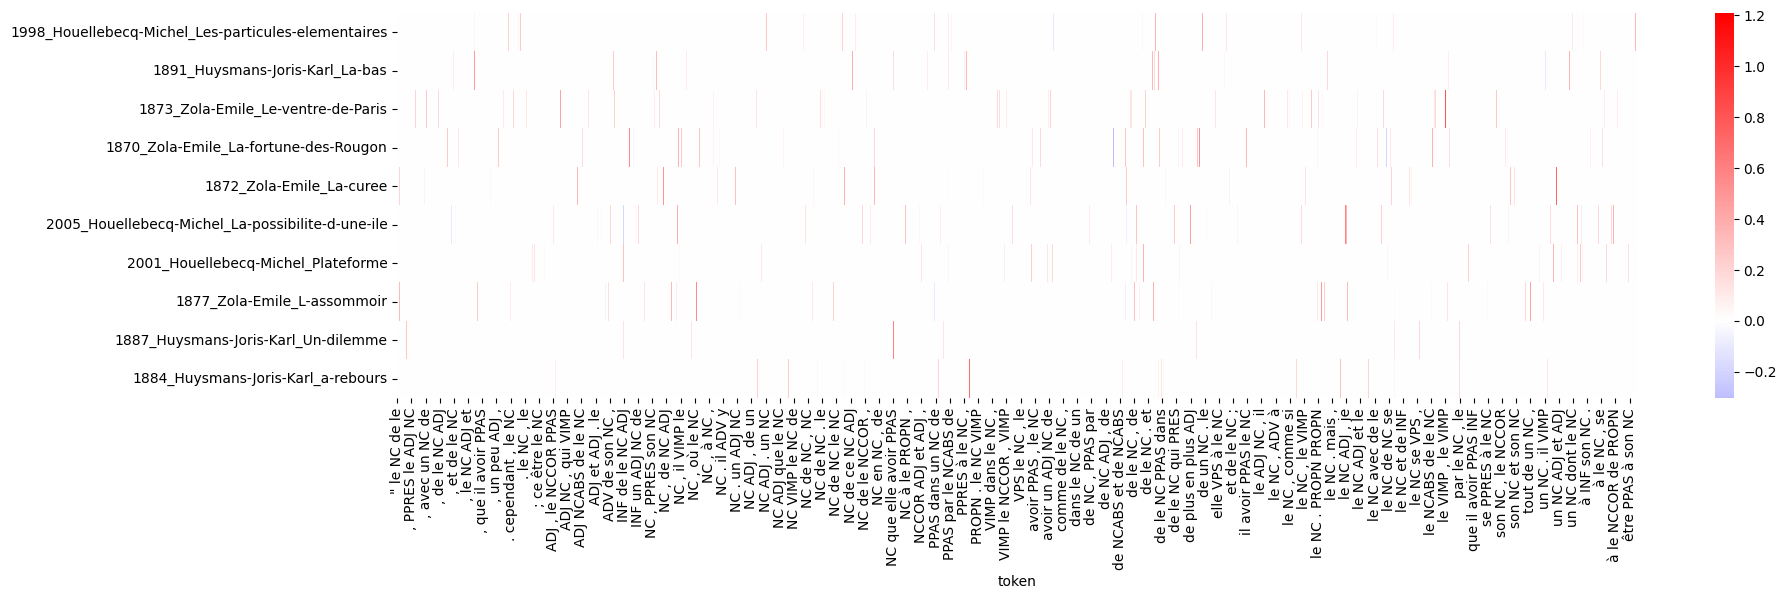

In [40]:


from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class='multinomial', solver='saga', penalty='l1', C=0.99, random_state=random_state,
)
clf.fit(train_features, train_y)

print("Train accuracy", clf.score(train_features, train_y) * 100)
print("Test accuracy", clf.score(test_features, test_y) * 100)
print("Sparisty", np.mean(clf.coef_ == 0) * 100)

coefs = pd.DataFrame(clf.coef_, columns=train_tfidf.columns, index=class_mapper.keys())

plt.figure(figsize=(20,5))
sns.heatmap(coefs, cmap="bwr", center=0)
plt.show()

In [41]:
sum(coefs.loc['1998_Houellebecq-Michel_Les-particules-elementaires',:] != 0)

80

Nous observons que seuls 80 tokens sont sélectionnés pour prédire si un document appartient à « Les particules élémentaires ».

## Importance des caractéristiques

Le graphique ci-dessous représente les coefficients de régression pour chaque document, qui peuvent être interprétés comme l'importance des caractéristiques.

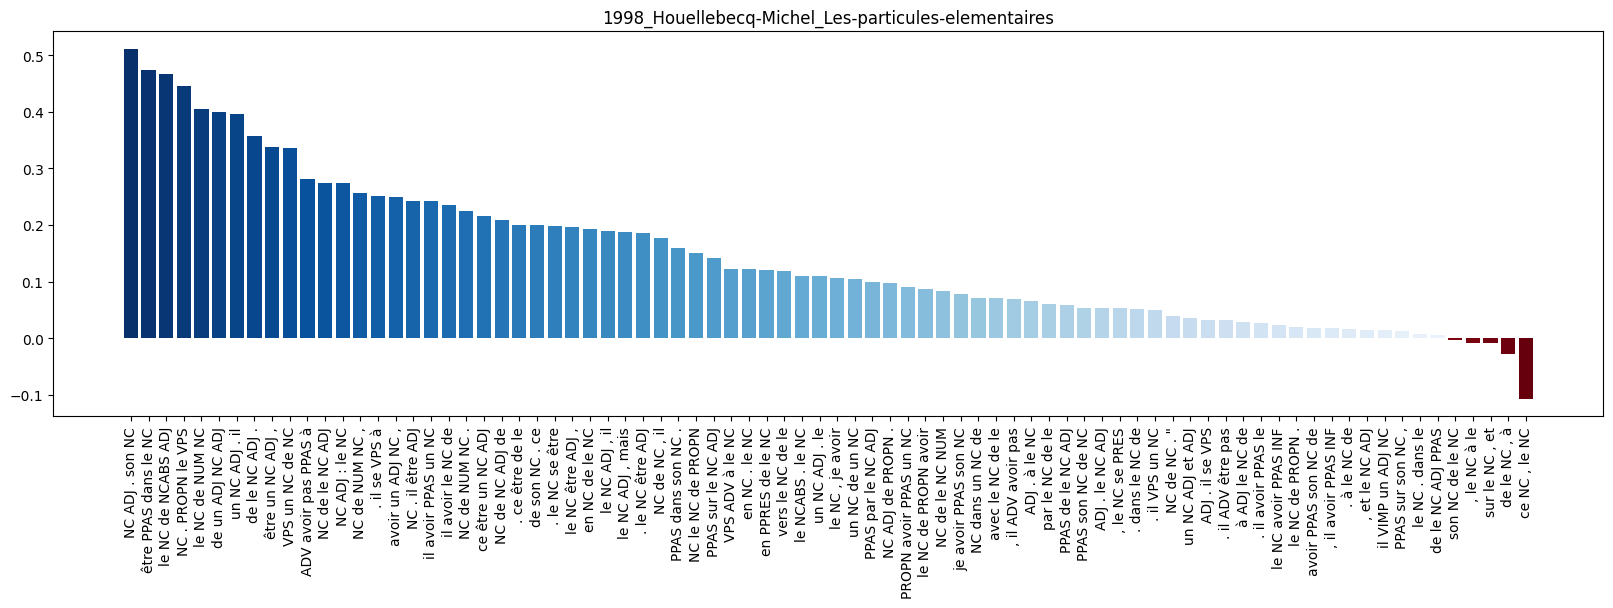

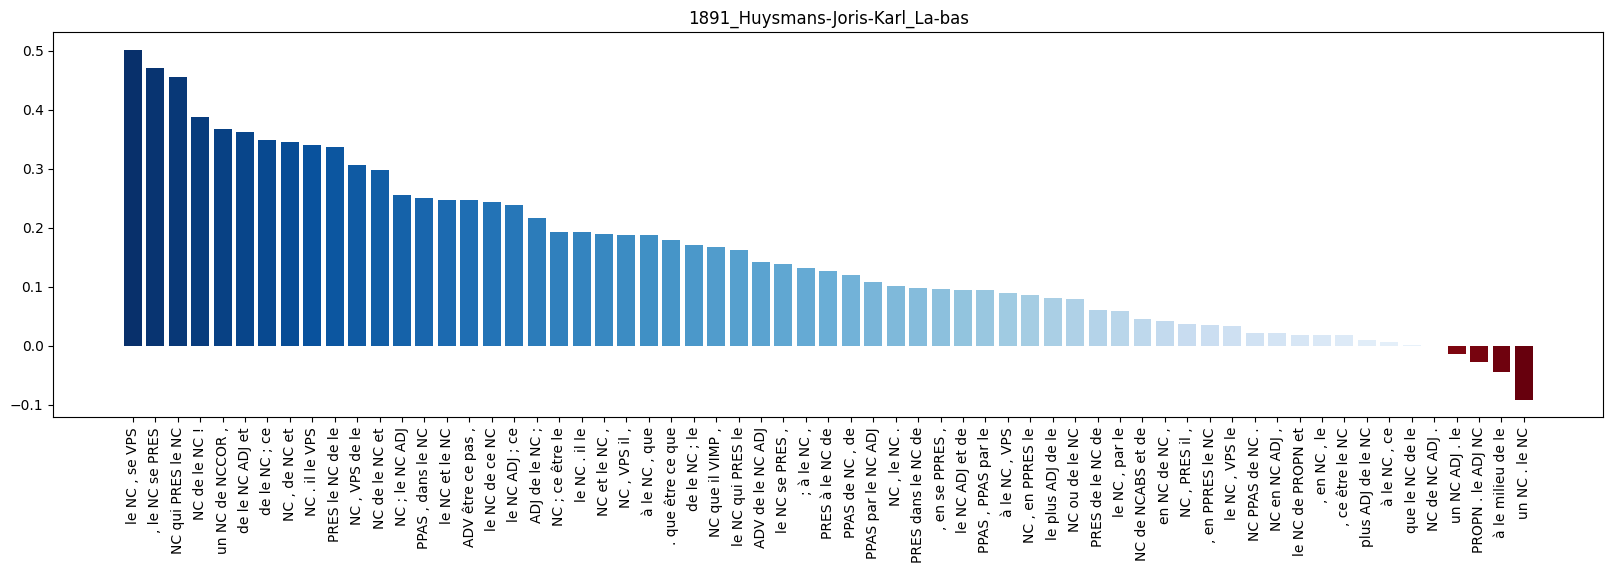

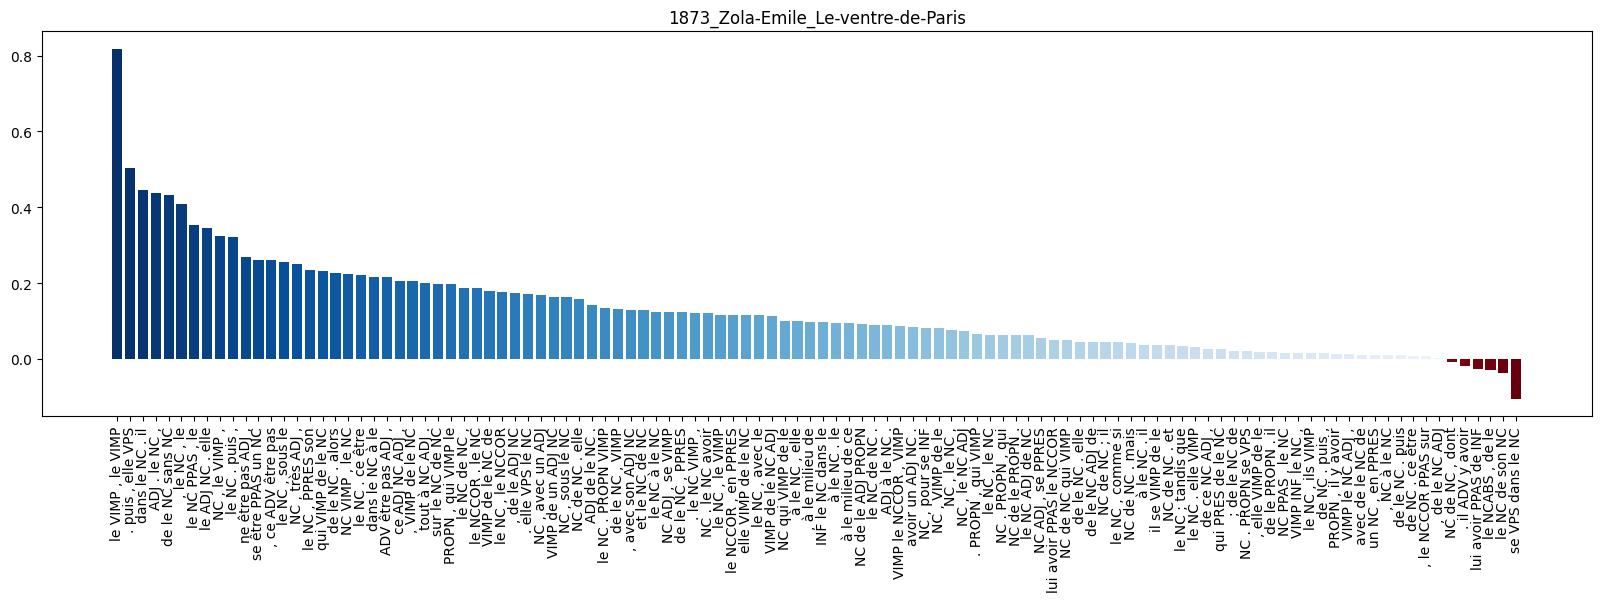

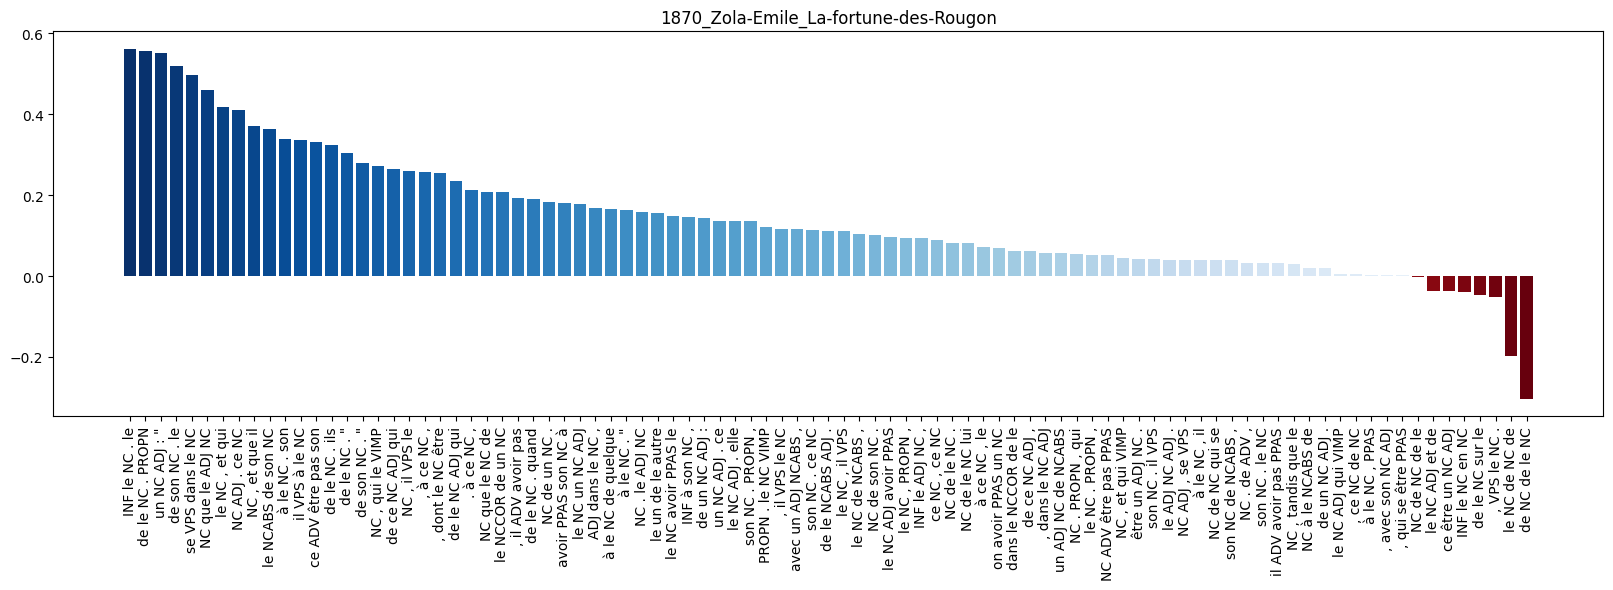

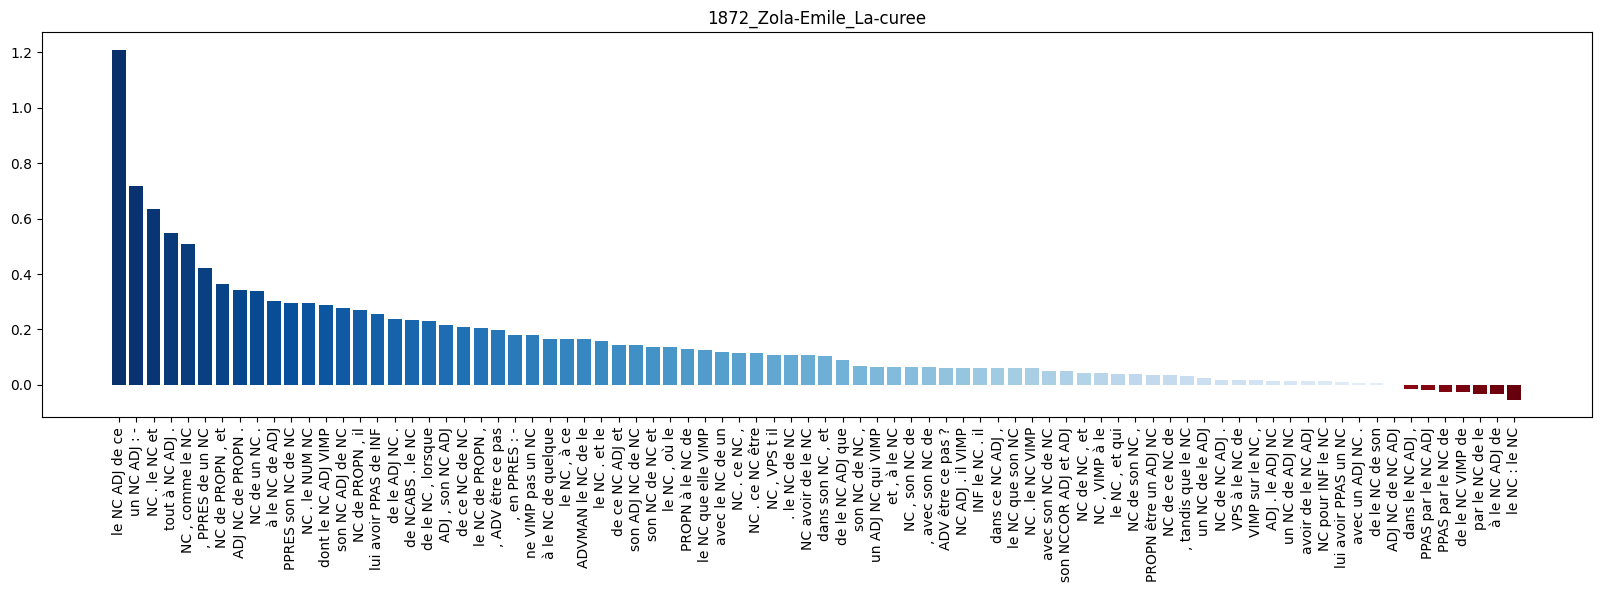

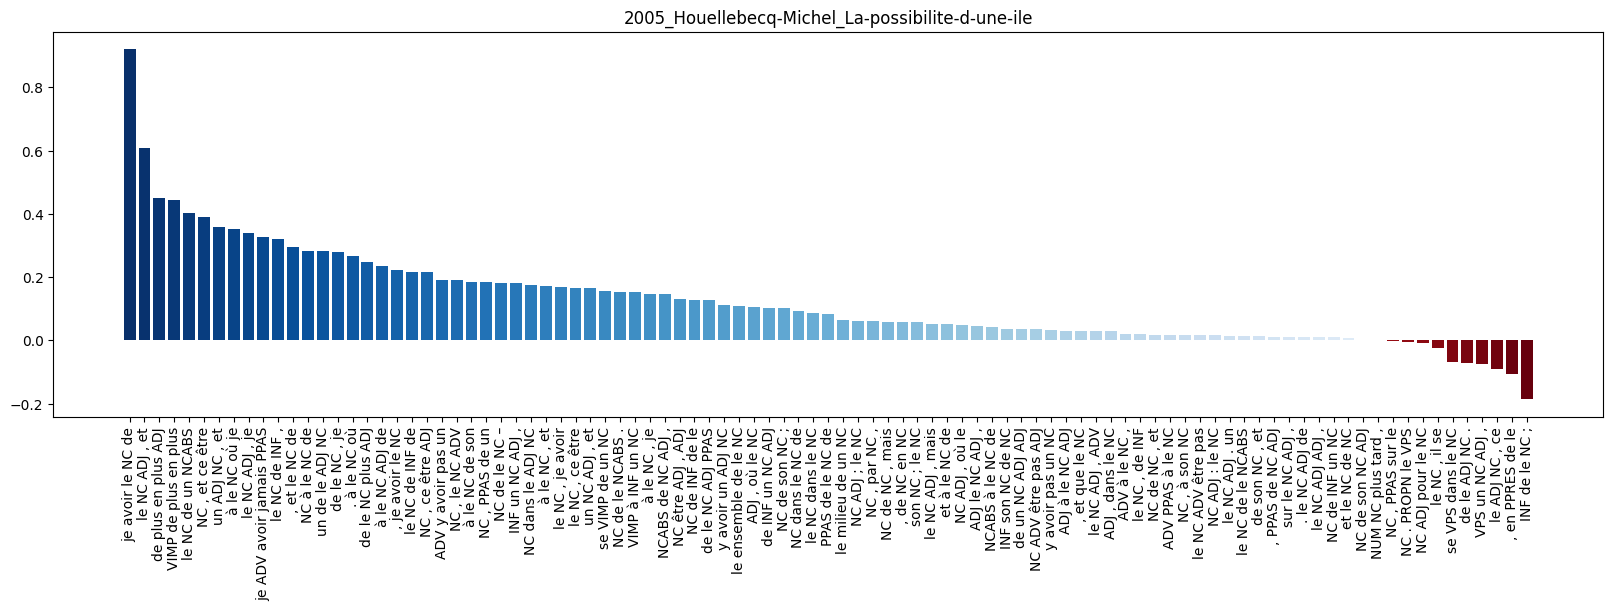

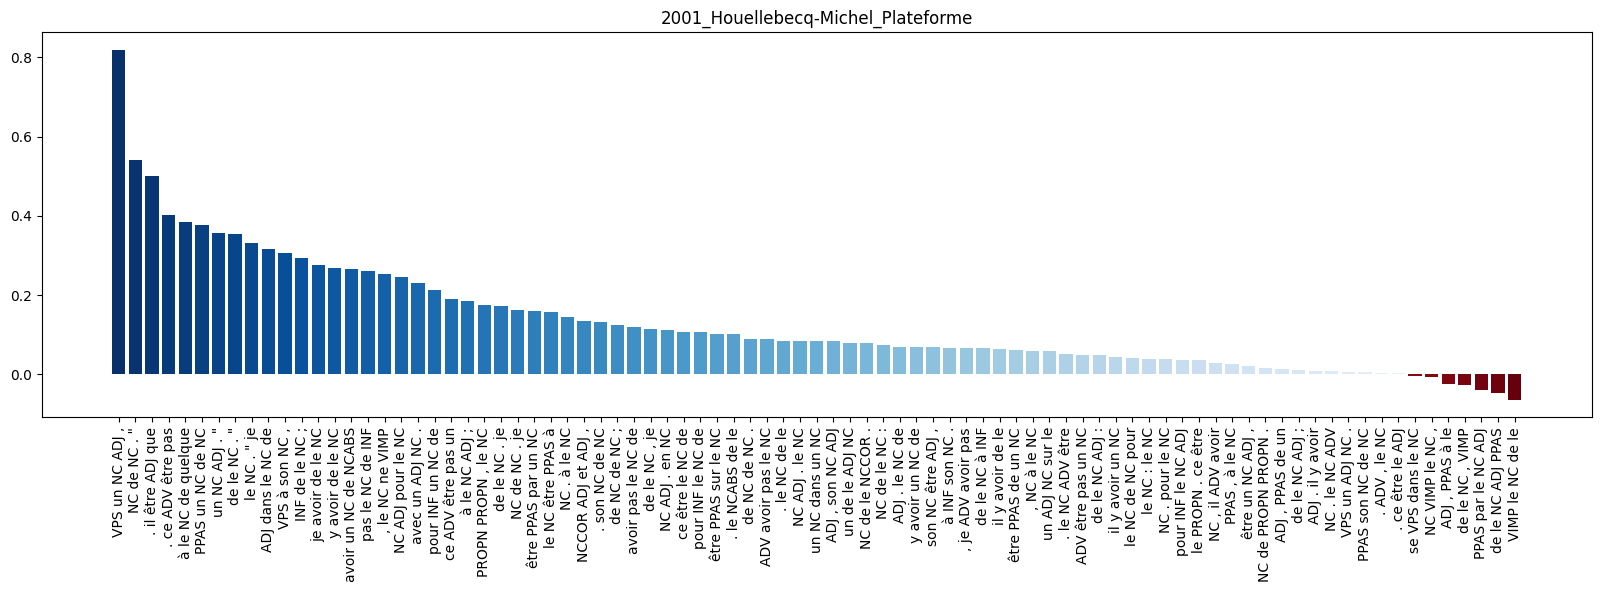

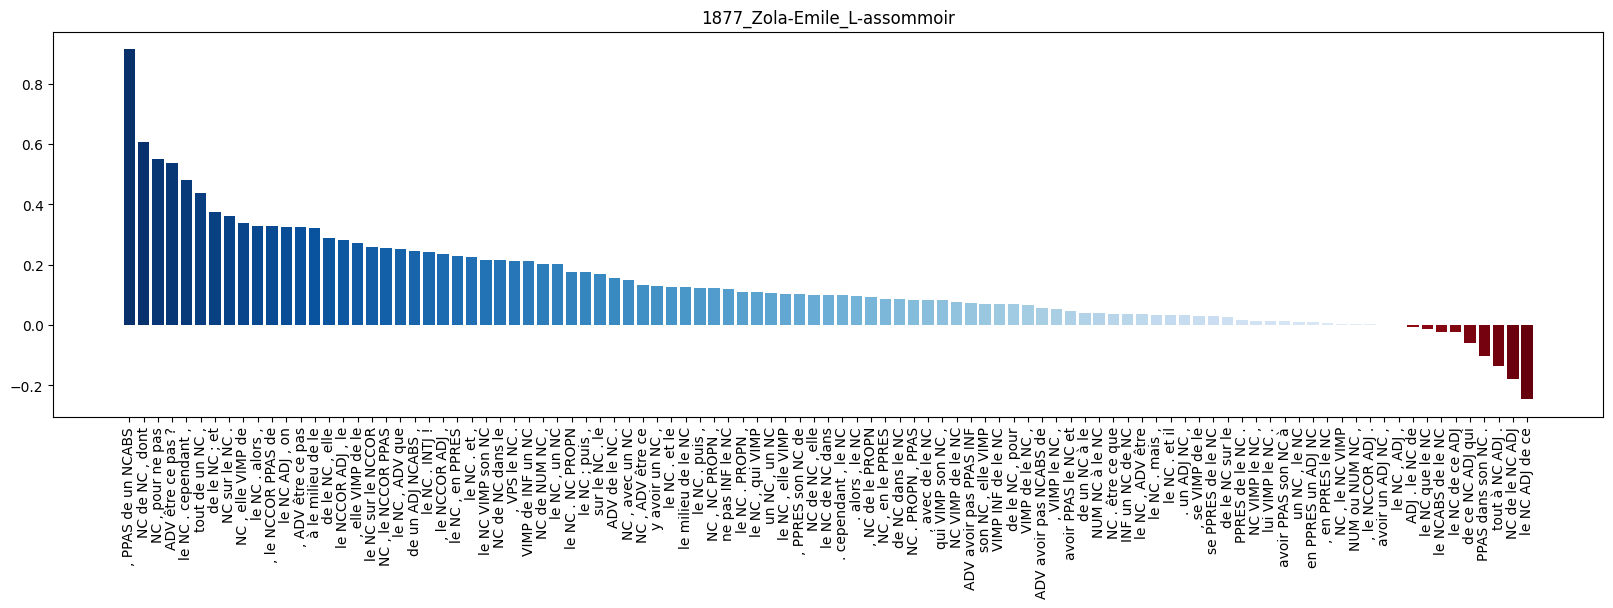

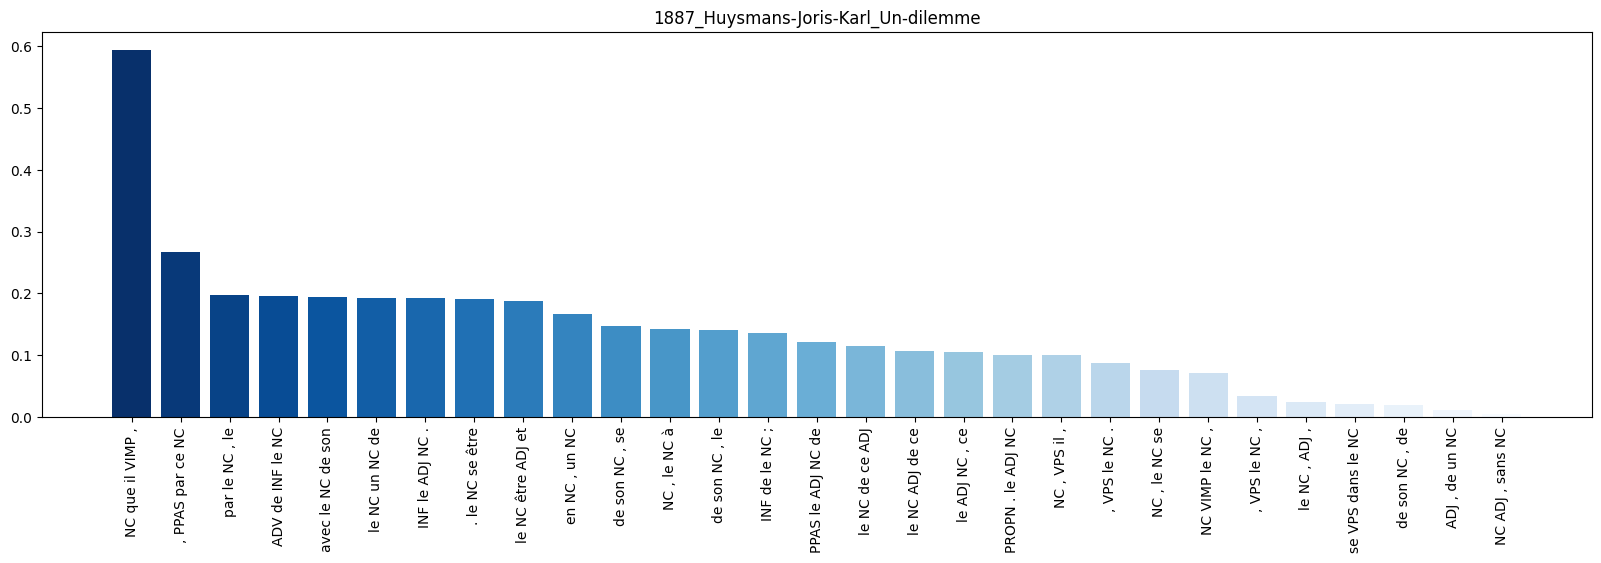

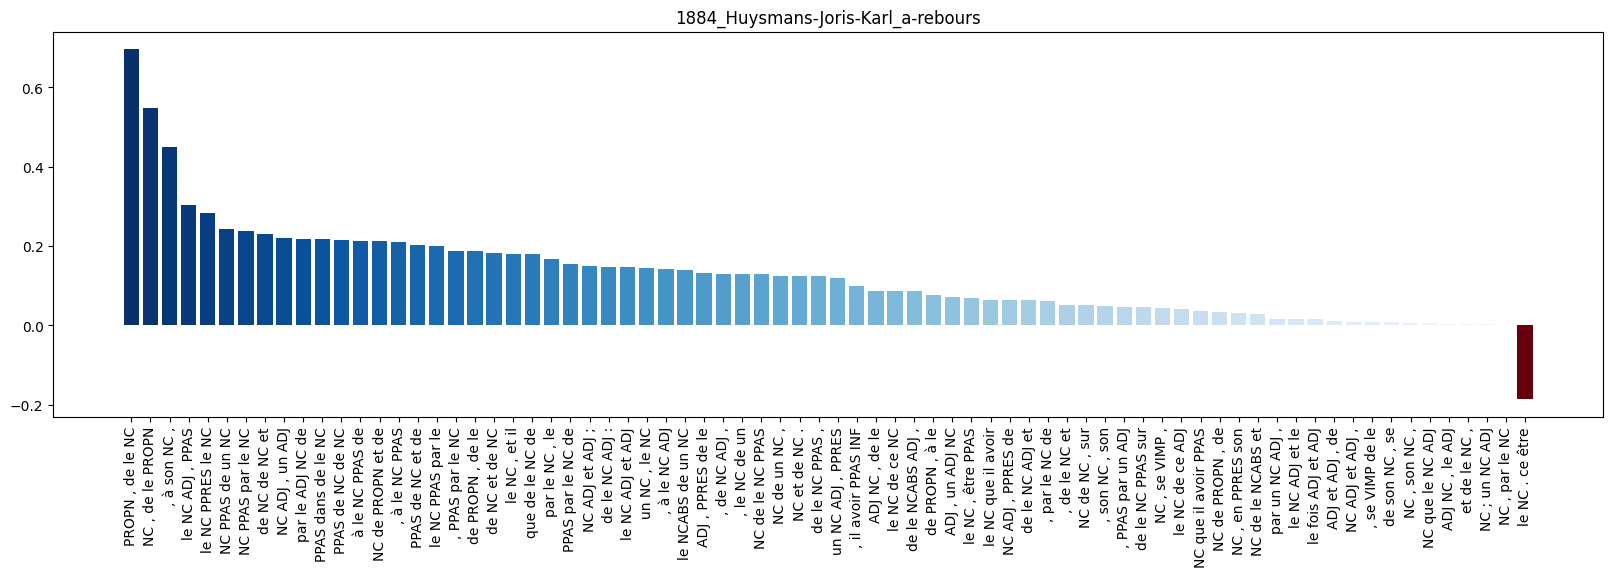

In [42]:
selected_features = {i: coefs.columns[coefs.loc[i] != 0].tolist() for i in coefs.index}
selected_features = {i: coefs.loc[i, f].sort_values(ascending=False) for i, f in selected_features.items()}

my_cmap = plt.get_cmap("bwr")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for i in selected_features:
    
    values = selected_features[i]
    # Separate positive and negative values
    positive_values = [val if val > 0 else 0 for val in selected_features[i]]
    negative_values = [val if val < 0 else 0 for val in selected_features[i]]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20,5))

    # Plot positive values with varying shades of blue
    ax.bar(range(len(positive_values)), positive_values, color=plt.cm.Blues(np.linspace(0, 1, len(positive_values)))[::-1])

    # Plot negative values with varying shades of red
    ax.bar(range(len(negative_values)), negative_values, color=plt.cm.Reds(np.linspace(0, 1, len(negative_values))))

    # Customize the plot
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(selected_features[i].index, rotation=90)
    ax.set_title(i)
    plt.show()

In [43]:
most_important_motifs = coefs.idxmax(1)
doc = "1998_Houellebecq-Michel_Les-particules-elementaires"
print(most_important_motifs[doc], coefs.loc[doc, most_important_motifs[doc]])

NC ADJ . son NC 0.510959


Le motif le plus important pour « Les particules élémentaires » de Houellebecq est « NC ADJ . son NC » avec un coefficient de 0,51. Il a un impact positif sur la probabilité qu'un texte soit « Les particules élémentaires » de Houellebecq.

## Return to text

In [44]:
context_len = 8
doc = "1998_Houellebecq-Michel_Les-particules-elementaires"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

left_context  \
0        ; puis il les photographiait , sous une   
1            , son clan avait été décimé par une   
2    Le lendemain de l' enterrement eut lieu une   
3      , que son adolescence en général était un   
4           en acier , qui avait été inauguré l'   
5                   de sept ans , à le milieu de   
6              qu' en haut , elle avait passé un   
7   " Huxley appartenait à une grande famille de   
8        , il a beaucoup écrit pour défendre les   
9      l' élément passif de le déploiement d' un   
10        qui provoque chez eux de les crises de   
11         c' est une coïncidence , mais pas une   
12                dix mille lits , ce qui est un   
13           peu , que son visage se couvrait de   

                                         text  \
0             lumière rasante . Son reportage   
1              éruption volcanique . Son père   
2                    scène étrange . Son père   
3                 échec lamentable . Son père   
4                 année précédente . Sa tante   
5   semi-brutes alcooliques . Son adolescence   
6                 sweat-shirt gris . Son mont   
7        biologistes anglais . Son grand-père   
8           thèses évolutionnistes . Son père   
9      mouvement historique . Ses motivations   
10   mégalomanie égocentrique . Leur objectif   
11         coïncidence stupéfiante . Mes cons   
12          record mondial . Leur appartement   
13                plaques rouges . Sa maladie   

                                        right_context  \
0     sur Saint-Tropez connut un grand succès dans le   
1                        , Craô le Sage , n' avait pu   
2                     et sa mère , qu' il voyait tous   
3                s' en rendait compte , et se sentait   
4   Marie-Thérèse et sa cousine Brigitte l' attend...   
5               avait été trop brève pour qu' elle en   
6   de Vénus avait une jolie courbure ; malheureus...   
7                       était un ami de Darwin , il a   
8        et son frère Julian étaient également de les   
9                   , ses valeurs , ses désirs : rien   
10  est alors de transformer leur environnement so...   
11  de parents appartenaient à ce milieu libertaire ,   
12                        , d' une surface de 22 m2 ,   
13                  de dos ne s' arrangeait pas , dit   

                                                  doc            token  
0   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
1   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
2   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
3   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
4   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
5   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
6   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
7   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
8   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
9   1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
10  1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
11  1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
12  1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC  
13  1998_Houellebecq-Michel_Les-particules-element...  NC ADJ . son NC

Un des motifs qui semblent permettre au modèle de très fortement reconnaître le Houellebecq des « Les particules élémentaires » sont ces fin de phrases constituées d'un NC et d'un ADJ relancées par un possessif et un NC. 
On peut identifier et modéliser l'utilisation de structures de linguistiques qui font appels à des grands concepts généraux chers également aux Particules élémentaires que le modèle utilise grandement pour former sa prédiction : "le concept de dignité humaine", "le postulat d'objectivité forte", "les valeurs de libération individuelle", "les décennies de surestimation insensée"...

In [61]:
return_to_text_from_token(ngrams[ngrams['doc']== doc], 'le NC de NCABS ADJ', n, context_len=9)

left_context  \
0   coordination suffisante de ses fonctions organ...   
1   même , avec quelques médicaments ; exempte jus...   
2   les mutations incontrôlables , le plus souvent...   
3   ontologie d' objets et de propriétés , solidai...   
4   avec de les saucisses de Montbéliard artisanal...   
5   de les matérialistes absolus , de les jouisseu...   
6   avait fait que prolonger et que mettre en prat...   
7        fait à la hauteur . Il éprouvait pourtant de   
8   de leur vie professionnelle ) . L' aplatisseme...   
9         son nez , examina les feuillets à nouveau ,   
10           Non , la situation n' avait pas évolué ;   
11  global dans lequel avaient subitement sombré ,...   

                                        text  \
0              le concept de dignité humaine   
1            la fin de souffrances physiques   
2   Les effets de stimulation intellectuelle   
3           le postulat d' objectivité forte   
4               l' état de détente plaisante   
5       la recherche de sensations nerveuses   
6     les valeurs de libération individuelle   
7              les moments de plaisir inouïs   
8    les critères de séduction intellectuels   
9       l' impression de compétence générale   
10                 les états de coma profond   
11   les décennies de surestimation insensée   

                                        right_context  \
0   . Les problèmes éthiques ainsi posés par les âges   
1                   ; de fait , jusqu' à présent , il   
2                    de le jeûne sont réels , et à l'   
3    , Djerzinski l' avait dans une large mesure déjà   
4                de l' homme que l' on vient de faire   
5   de plus en plus violentes . Selon Daniel Macmi...   
6   prônées par son père . Macmillan appartenait à le   
7     , fulgurants , à la limite de l' évanouissement   
8   et moraux à le profit de critères purement phy...   
9     en fut sensiblement augmentée . Il n' était pas   
10  pouvaient être très stables , lui rappela l' i...   
11             , les travaux de Foucault , de Lacan ,   

                                                  doc               token  
0   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
1   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
2   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
3   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
4   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
5   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
6   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
7   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
8   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
9   1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
10  1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ  
11  1998_Houellebecq-Michel_Les-particules-element...  le NC de NCABS ADJ

In [45]:
doc = "1891_Huysmans-Joris-Karl_La-bas"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

left_context  \
0     commença de vivre dans le pacifiant mépris de   
1     organisa une existence loin de le brouhaha de   
2                tourna sur la console , le long de   
3                    à le plus vite , ses bras dans   
4                se glissa , emplit la robe , bomba   
5                , jusqu' à l' entrée ; elle ouvrit   
6                     son tour , s' en fut jusqu' à   
7           bête . Il jeta de nouvelles bûches dans   
8            c' est l' incarnation de le maudit sur   
9               d' ennui . Il se déshabilla près de   
10             , finit par croire à l' existence de   
11  s' interrompit . Le prêtre descendit à reculons   
12                       se tut , ne se mêla plus à   
13              les meubles . Puis il s' élança sur   
14            ville . Il chanta de les psaumes dans   

                           text  \
0   les alentours , s' organisa   
1      les lettres , se cloîtra   
2           le mur , se dirigea   
3         le lit , s' acagnarda   
4       le corsage , s' insinua   
5        la porte , se retourna   
6          la porte , s' assura   
7        la cheminée , se vêtit   
8           la terre , s' écria   
9           le feu , se chauffa   
10     l' enfant , s' attendrit   
11  les marches , s' agenouilla   
12   la conversation , se borna   
13          le lit , se colleta   
14        les rues , s' engagea   

                                    right_context  \
0        une existence loin de le brouhaha de les   
1          mentalement , pour tout dire , dans le   
2   vers la lumière qui pénétrait par les auvents   
3            sous ses couvertures . C' est un bon   
4              sous le hennin à deux cornes d' où   
5            , lui prit la main et très doucement   
6                      , d' un coup d' oeil , qu'   
7         , laissa à Hyacinthe la chambre libre .   
8         Carhaix , en aidant ses amis à endosser   
9          , attendant qu' elle fut couchée . Une   
10                   sur la mère et sur elle ; sa   
11               sur la dernière et , d' une voix   
12        à remplir les verres , à assaisonner la   
13          , comme un lutteur , avec les matelas   
14             , par serment , dans les églises ,   

                                doc           token  
0   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
1   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
2   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
3   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
4   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
5   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
6   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
7   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
8   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
9   1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
10  1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
11  1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
12  1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
13  1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS  
14  1891_Huysmans-Joris-Karl_La-bas  le NC , se VPS

In [46]:
doc = "1873_Zola-Emile_Le-ventre-de-Paris"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

left_context  \
0               , marquaient la viande d' un timbre ,   
1              viande d' un timbre , la voituraient ,   
2                  de l' origine de sa fortune ; cela   
3              oncle Gradelle et sur les Quenu ; elle   
4          quinzaine de jours , l' arrivée de Florent   
5                comme on disait la belle Lisa . Cela   
6                 la belle Lisa . Cela les opposait ,   
7                    , il les prenait avec un bâton ,   
8           une poignée la paille de les bourriches ,   
9   coquetterie maladroite qui tachait les murs . ...   
10       filant dans le ruissellement de les allées ,   
11            cœur . Il heurtait tous ses instincts ,   
12        heurtait tous ses instincts , la blessait ,   
13       osier , riant lorsqu' un élan trop vigoureux   
14     , les échantillons de les différents beurres ,   
15                  le mélanger avec l' eau ; et elle   
16              les cornichons , le plus souvent . Il   
17          comptoir . La vue de la belle charcutière   

                               text  \
0      la voituraient , la pesaient   
1     la pesaient , l' accrochaient   
2          le gênait , l' empêchait   
3      les détaillait , les prenait   
4      la désorientait , la brûlait   
5      les opposait , les comparait   
6       les comparait , les forçait   
7       les enroulait , les portait   
8       les vidaient , les jetaient   
9   le rafraîchissait , le ramenait   
10      l' occupaient , le menaient   
11     la blessait , l' épouvantait   
12      l' épouvantait , la rendait   
13       les enlevait , les lançait   
14      les mêlait , les corrigeait   
15       l' allumait , le regardait   
16       les adorait , les mangeait   
17        le ravissait , le faisait   

                                        right_context  \
0                , l' accrochaient à les barres de la   
1                   à les barres de la criée ; tandis   
2                 de dire tout net son opinion sur la   
3                   par tous les bouts , les savait "   
4         d' une véritable fièvre de curiosité . Elle   
5        , les forçait à soutenir chacune sa renommée   
6          à soutenir chacune sa renommée de beauté .   
7               dans la cour , où ils devaient sécher   
8                    , vivement ; et , sur les larges   
9                     à de les rêves de jeunesse . Il   
10               jusqu' à le déjeuner , heureux de l'   
11  , la rendait véritablement malheureuse . Elle ...   
12  véritablement malheureuse . Elle murmura encor...   
13                 par-dessus le tas , à le milieu de   
14                     l' un par l' autre , ainsi qu'   
15        brûler , très sérieuse , fumant lentement ,   
16              avec son rire d' innocent , devant le   
17                taper de joie dans ses mains . Puis   

                                   doc              token  
0   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
1   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
2   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
3   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
4   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
5   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
6   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
7   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
8   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
9   1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
10  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
11  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
12  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
13  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
14  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
15  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
16  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , le VIMP  
17  1873_Zola-Emile_Le-ventre-de-Paris  le VIMP , l

Ici, nous observons probablement plus d'un motif si nous avions utilisé un ngram plus long. Les structures énumératives de verbes à l'imparfait peuvent être en rythmes ternaires.
Cependant, cela montre que la longueur du n-gram n'est pas si importante pour capturer des motifs spécifiques dans la mesure où nous les identifions en revenant aux textes et que cela permet une plus grande flexibilité du motif.

In [62]:
doc = "1872_Zola-Emile_La-curee"
context = return_to_text_from_token(ngrams[ngrams["doc"] == doc], most_important_motifs[doc], n, context_len)
context

left_context  \
0                   eau et de le gazon . Accoutumée à   
1      de fruits et de feuillages , s' épanouissaient   
2         verdures noires , ces tiges colossales ; et   
3              attention . Il ne tarda pas à pénétrer   
4             et le demi-jour de l' appartement , par   
5               les vacances , Renée vivait là , dans   
6        effet , la troublait profondément . C' était   
7                   , de les trous de ténèbres , dans   
8            . Il préférait garder le luxe inutile et   
9           , dans ses jupons dénoués , elle semblait   
10   Renée avait enfin empli d' une jouissance chaude   
11  les attelages , goûtaient de véritables douceu...   
12             plaisaient à le parc Monceau , comme à   
13                  de la pièce , on n' entendait que   
14      son entourage s' était retirée et cachée sous   
15                  Saffré pour amant . Il n' eut que   
16               grappe , ou fleurissant à l' écart ,   
17                    , sous la pâleur de la blouse ;   
18             cette heure , elle se souciait bien de   
19                   se sentait , elle , le produit ,   
20         meuble . Rien n' était plus lamentable que   

                                     text  \
0              les grâces savantes de ces   
1           les pièces capitales de cette   
2              les couches âcres de cette   
3                 le labeur immense de ce   
4                la sévérité triste de ce   
5                     le bain jaune de ce   
6              le parfum persistant de ce   
7            le tohu-bohu féerique de ces   
8                 la misère réelle de ces   
9                   la sœur blanche de ce   
10                 le vide glacial de ces   
11             les couleurs tendres de ce   
12        la plate-bande nécessaire de ce   
13                     le tic -tac de ces   
14                    l' habit noir de ce   
15            le sourire mauvais de cette   
16  les efflorescences féeriques de cette   
17                 la ligne pure de cette   
18               les regards clairs de ce   
19                 le fruit véreux de ces   
20              les papiers peints de ces   

                                        right_context  \
0                 points de vue , Renée , reprise par   
1   décoration étonnante , les frontons de les pav...   
2            mer de feu , cet épanouissement de forêt   
3                  petit être pâle et vague , dont la   
4           grand vieillard , dont l' œil perçant lui   
5             bon soleil , qui semblait heureux de la   
6   singulier foyer domestique . Cependant Maxime ...   
7     mille flammes dansantes , sortant comme un flot   
8               voies nouvelles , d' où il avait tiré   
9           dieu noir . Maxime resta languissant . La   
10       plafonds dorés . Cette maison suspecte de le   
11             grand jardin . Un bout de grille dorée   
12             Paris nouveau , étalant son luxe à les   
13               aiguilles . Renée s' assit , gênée ,   
14           laquais . Elle demanda un jour à Céleste   
15           méchanceté , et , jetant son cigare dans   
16               grotte , où les califes de les Mille   
17             nudité se retrouvait , de les genoux à   
18                   valet ! À la porte , le cotillon   
19           deux hommes , l' infamie qu' ils avaient   
20           chambres , de les carrés jaunes ou bleus   

                         doc            token  
0   1872_Zola-Emile_La-curee  le NC ADJ de ce  
1   1872_Zola-Emile_La-curee  le NC ADJ de ce  
2   1872_Zola-Emile_La-curee  le NC ADJ de ce  
3   1872_Zola-Emile_La-curee  le NC ADJ de ce  
4   1872_Zola-Emile_La-curee  le NC ADJ de ce  
5   1872_Zola-Emile_La-curee  le NC ADJ de ce  
6   1872_Zola-Emile_La-curee  le NC ADJ de ce  
7   1872_Zola-Emile_La-curee  le NC ADJ de ce  
8   1872_Zola-Emile_La-curee  le NC ADJ de ce  
9   1872_Zola-Emile_La-curee  le NC ADJ de ce  
10  1872_Zol

Motif descriptif par excellence...